# Student Name: Ferreira da Silva LUCAS
# Student No.: 2311328
# Laboratory: Optical Media Interface Lab

# Exercise 2.2: Interpolation of two-dimensional signal

## - Create a routine to find the amount of deformation at every pixel on the image by interpolating the amount of deformation at each point using 2D Bernstein polynomial interpolation.
## - Using the routine, create an image (c) by deforming image (b) and embedding the non-white pixels onto the image (a). 

In [1]:
# Lucas 2024/01/04
# All imports go here

import numpy as np
from scipy.special import comb
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2

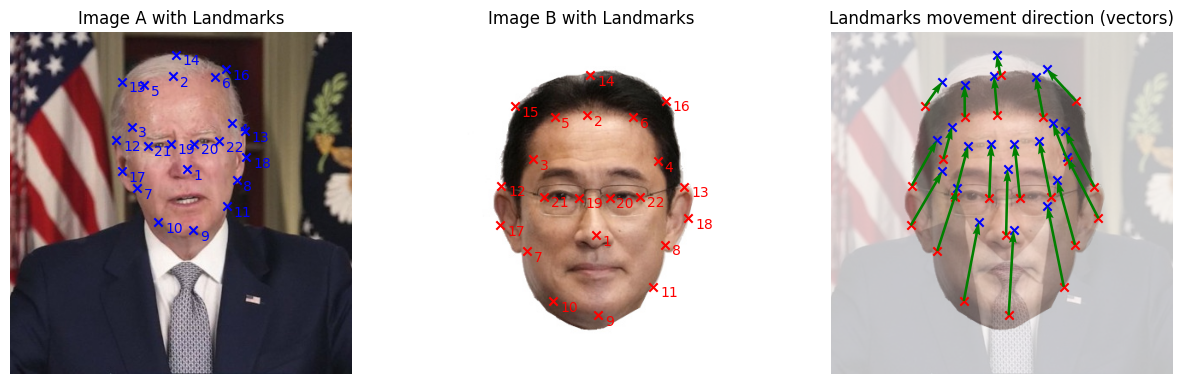

In [9]:
# Lucas 2024/01/04
# Load Data

# Path to the file containing landmark points
file_path = '../Assignment2/CorrespondingPoint.txt'

# Initialize lists to hold the landmark points for both images
landmark_points_a = []
landmark_points_b = []

# Read the file and parse the data
with open(file_path, 'r') as file:
    # Skip the first line which contains the number of points and the filename
    next(file)
    # Read the rest of the lines
    for line in file:
        # Split the line by comma and convert the values to floats
        x_a, y_a, x_b, y_b = map(float, line.strip().split(','))
        
        # Append the landmark points for images a and b
        landmark_points_a.append((x_a, y_a))
        landmark_points_b.append((x_b, y_b))
    
# Lucas 2024/01/04
# Read Images
image_a = Image.open('../Assignment2/Biden_face.jpg')
image_b = Image.open('../Assignment2/Kishida_face.jpg')

# Convert images to numpy arrays
array_a = np.array(image_a)
array_b = np.array(image_b)

# Unpack the landmark points for easier plotting
landmarks_a_x, landmarks_a_y = zip(*landmark_points_a)
landmarks_b_x, landmarks_b_y = zip(*landmark_points_b)

# Compute deformation_vectors
# Based on: https://stackoverflow.com/questions/49783594/for-loop-and-zip-in-python
deformation_vectors = []
for (x_b, y_b), (x_a, y_a) in zip(landmark_points_b, landmark_points_a):
    dx = x_a - x_b
    dy = y_a - y_b
    deformation_vectors.append((dx,dy))

# Create subplots 1x3 -> (image a with landmarks, image b with landmarks, deformation array)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot image a with landmarks
axs[0].imshow(array_a)
axs[0].scatter(landmarks_a_x, landmarks_a_y, c='b', marker='x', label='Landmarks Image A')
# based on: https://stackoverflow.com/questions/41561919/displaying-coordinates-next-to-points-in-a-3d-scatter-plot-with-python
for i, (x, y) in enumerate(zip(landmarks_a_x, landmarks_a_y), 1):
        axs[0].text(x + 8, y + 12, str(i), color='b', fontsize=10)
axs[0].set_title('Image A with Landmarks')
axs[0].axis('off')

# Plot image b with landmarks
axs[1].imshow(array_b)
axs[1].scatter(landmarks_b_x, landmarks_b_y, c='r', marker='x', label='Landmarks Image B')
for i, (x, y) in enumerate(zip(landmarks_b_x, landmarks_b_y), 1):
        axs[1].text(x + 8, y + 12, str(i), color='r', fontsize=10)
axs[1].set_title('Image B with Landmarks')
axs[1].axis('off')

# New subplot for combined landmarks with arrows
axs[2].imshow(array_a, alpha=0.5)  # image A, with some transparency
axs[2].imshow(array_b, alpha=0.5)  # image B, with some transparency
axs[2].scatter(landmarks_a_x, landmarks_a_y, c='b', marker='x', label='Landmarks Image A')
axs[2].scatter(landmarks_b_x, landmarks_b_y, c='r', marker='x', label='Landmarks Image B')
# Draw arrows from landmarks in B to landmarks in A
# based on: https://www.geeksforgeeks.org/quiver-plot-in-matplotlib/
for (x_b, y_b), (x_a, y_a) in zip(landmark_points_b, landmark_points_a):
    axs[2].quiver(x_b, y_b, x_a - x_b, y_a - y_b, angles='xy', scale_units='xy', scale=1, color='green')
axs[2].set_title('Landmarks movement direction (vectors)')
axs[2].axis('off')

plt.savefig(f'../OUTPUT/assignment_2_2_images_with_landmarks.jpg')
plt.show()

In [3]:
# Lucas 2024/01/15
# Let us normalize the deformation vectors
# If we don't do so, the results are worst and very misaligned
# Tried different normalizations but this one was got us the best 
# results we managed to obtain

# Z Score Normalization
# Baseed on: https://datagy.io/python-z-score/
mean_dx = np.mean([vec[0] for vec in deformation_vectors])
std_dx = np.std([vec[0] for vec in deformation_vectors])
mean_dy = np.mean([vec[1] for vec in deformation_vectors])
std_dy = np.std([vec[1] for vec in deformation_vectors])

deformation_vectors = [((dx - mean_dx) / std_dx, (dy - mean_dy) / std_dy) 
                                  for dx, dy in deformation_vectors]

In [4]:
# Lucas 2024/01/15
# Define the function that computes the value of the 2D Bernstein
# polynomial given the degree of the polynomial, indices, and the normalized coordinates x and y.

def bernstein_polynomial_2d(n, i, j, x, y):
    """
    Compute the (i, j)-th Bernstein polynomial of degree n at (x, y).

    Parameters:
    - n: polynomial degree
    - i, j: indices for x and y
    - x, y (float): normalized points in image

    Returns:
    - The (i, j)-th Bernstein polynomial of degree n at (x, y)
    """
    return comb(n, i) * comb(n, j) * np.power(x, i) * np.power(1 - x, n - i) * np.power(y, j) * np.power(1 - y, n - j)

# Lucas 2024/01/15
# Using the Bersntein 2D polynomial, interpolate the deformation in all image pixels

def compute_deformation_field_2d(image_width, image_height, degree, deformation_vectors):
    # Create grids of normalized coordinates
    # 400 points, from 0 to 1 (for x and y)
    # based on: https://stackoverflow.com/questions/35418012/how-to-create-matrix-of-points-by-x-y-coordinate-in-python
    x_normalized, y_normalized = np.meshgrid(np.linspace(0, 1, image_width), np.linspace(0, 1, image_height))

    # Initialize deformation field with zeros
    # index 0 stores x deformation, index 1 stores y deformation for each pixel
    deformation_field = np.zeros((image_height, image_width, 2))
    # sort by x ascending, somehow, this improves the result
    # source: https://sparkbyexamples.com/python/sort-using-lambda-in-python/
    deformation_vectors = sorted(deformation_vectors, key=lambda vec: (vec[0], vec[1]))

    # First pass: fix x, evaluate all y (as tip oriented)
    for x in tqdm(range(image_width)):
        x_value = x_normalized[0, x] # get the constant x
        for i in range(degree + 1): # over the index i of the polynomial
            for j in range(degree + 1): # over the index j of the polynomial
                b_poly = bernstein_polynomial_2d(degree, i, j, x_value, y_normalized[:, 0]) # compute poly
                # weight the deformation with the poly to interpoalte (estimate) deformation for all xy
                deformation_field[:, x,1] += b_poly * deformation_vectors[i][1] # Update y-component

    # now, sort by y ascending, somehow, improved results
    deformation_vectors = sorted(deformation_vectors, key=lambda vec: (vec[1], vec[0]))

    # Second pass: fix y, evaluate all x (as tip oriented)
    # same idea above for x
    for y in tqdm(range(image_height)):
        y_value = y_normalized[y, 0]
        for i in range(degree + 1):
            for j in range(degree + 1):
                b_poly = bernstein_polynomial_2d(degree, i, j, x_normalized[y, :], y_value)
                deformation_field[y, :, 0] += b_poly * deformation_vectors[j][0]  # Update x-component
    
    return deformation_field

    
# Lucas 2024/01/15
# Compute the degree of the polynomial
# Use all landmarks
degree = len(landmark_points_a) - 1

# img dimensions
image_width = 400
image_height = 400

# Get the deformation field for the whole 400x400 iamge
deformation_field_2d = compute_deformation_field_2d(image_width, image_height, degree, deformation_vectors)

print(f"Computed the 2D Bernstein polynomial with degree {degree} for coefficients for each pixel.")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.44it/s]

Computed the 2D Bernstein polynomial with degree 21 for coefficients for each pixel.


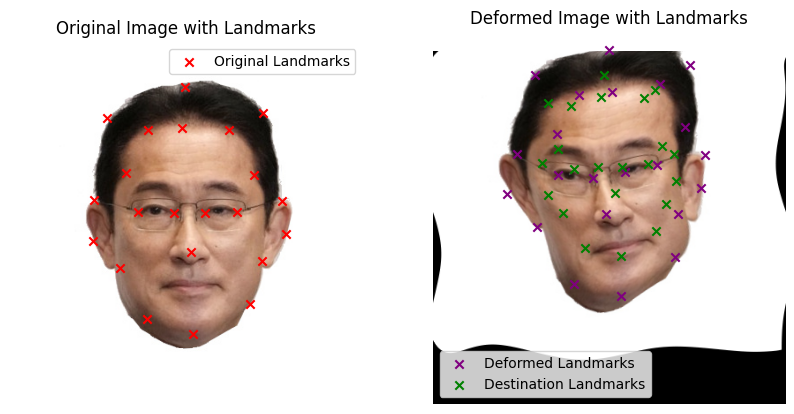

In [7]:
# Lucas 2024/01/15
# Deform Image (b) with the deformation_field computed above

def apply_deformation_to_landmarks(landmarks, deformation_field):
    """
    Tranform the original landmarks for checking final position
    after applying the deformation interpolation
    """
    deformed_landmarks = []
    for x, y in landmarks:
        dx, dy = deformation_field[int(y), int(x)]
        deformed_landmarks.append((x - dx, y + dy)) # move the landmarks accordingly to deformation_field
    return deformed_landmarks
    
# Lucas 2024/01/15
# Prepare maps for cv2.remap function
# This function takes pixels from one image and move them to another,
# given a mapping from source image to target image
# based on: https://docs.opencv.org/4.x/d1/da0/tutorial_remap.html
# https://stackoverflow.com/questions/46520123/how-do-i-use-opencvs-remap-function
map_x = np.zeros((image_height, image_width), dtype=np.float32)
map_y = np.zeros((image_height, image_width), dtype=np.float32)

# Lucas 2024/01/15
# Denormalize x and y components (z-score denorm)
denormalized_deformation_field_2d = np.zeros_like(deformation_field_2d)
# first for x
denormalized_deformation_field_2d[:, :, 0] = deformation_field_2d[:, :, 0] * std_dx + mean_dx
# now for y
denormalized_deformation_field_2d[:, :, 1] = deformation_field_2d[:, :, 1] * std_dy + mean_dy

# Lucas 2024/01/15
# Iterate over the image and store deformations
for y in range(image_height):
    for x in range(image_width):
        dx, dy = denormalized_deformation_field_2d[y, x]
        map_x[y, x] = x - dx # this pixel will be moved dx
        map_y[y, x] = y - dy # this pixel will be moved dy

# Perform the remapping with opencv.remap, it requires an interpolation
# method, using bilinear interpolation
deformed_image_b = cv2.remap(array_b.copy(), map_x, map_y, cv2.INTER_AREA) # cv2.INTER_LINEAR or cv2.INTER_CUBIC
# convert to array
deformed_array_b = np.array(deformed_image_b.copy())

# Save the result
cv2.imwrite('../OUTPUT/assignment_2_2_deformed_Kishida_face.jpg', deformed_image_b)

# Get the deformated landmarks for image b
deformed_landmarks_b = apply_deformation_to_landmarks(landmark_points_b, denormalized_deformation_field_2d)

# Now plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot original image with original landmarks (landmark_points_b)
axs[0].imshow(array_b)
axs[0].scatter(*zip(*landmark_points_b), c='r', marker='x', label='Original Landmarks')
axs[0].set_title('Original Image with Landmarks')
axs[0].axis('off')
axs[0].legend()

# Plot deformed image with deformed landmarks
axs[1].imshow(deformed_image_b)
axs[1].scatter(*zip(*deformed_landmarks_b), c='purple', marker='x', label='Deformed Landmarks')
axs[1].scatter(*zip(*landmark_points_a), c='g', marker='x', label='Destination Landmarks')
axs[1].set_title('Deformed Image with Landmarks')
axs[1].axis('off')
axs[1].legend()
plt.savefig(f'../OUTPUT/assignment_2_2_image_b_deformed_image_b.jpg')
plt.show()

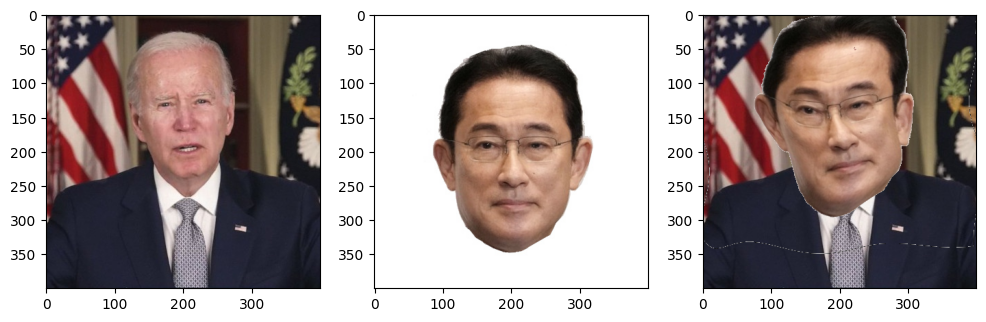

In [8]:
# Lucas 2024/01/15
# Move the distorted image over the Biden image

# Function to check if a pixel is considered 'white'
def is_pixel_white(pixel, threshold=200):
    return np.all(pixel > threshold)

# Function to check if a pixel is considered 'black' because
# the deformed image has some unwanted black values
def is_pixel_black(pixel, threshold=5):
    return np.all(pixel < threshold)

# Create an empty array for image c with the same shape as array a
array_c = array_a.copy()

# Overlay non-white pixels from the deformed image b onto image c
for y in range(400):
    for x in range(400):
        if not is_pixel_white(deformed_array_b[y, x]):
            if not is_pixel_black(deformed_array_b[y, x]):
                array_c[y, x] = deformed_array_b[y, x]

# Convert the array back to an image
image_c = Image.fromarray(array_c)

# Save the final combined image
image_c.save('../OUTPUT/assignment_2_2_interpolated_image.jpg')

# Plot
# Source: https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots
fig, ax = plt.subplots(1, 3, figsize=(12,6))
ax[0].imshow(image_a)
ax[1].imshow(image_b)
ax[2].imshow(image_c)
plt.savefig(f'../OUTPUT/assignment_2_2_result_images_a_b_c.jpg')
plt.show()